# Phase alignment evaluation on headphones recordings
Check for coherence in respiratory phases to the musical stimuli

Working from data of Headphones experiment

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act # 

In [2]:
# import respy functions from respy.py file
%load_ext autoreload
%autoreload 1
%aimport respy

Import the respiration data (corrected timing) and the stimulus timing information

In [3]:
# extract stimulus intervals
os.chdir('/Users/finn/Documents/Resp/RITMO/Heaphones_Speakers/')
stim_sequence = pd.read_csv('StimSequences.csv')
print(stim_sequence.columns)
stim_sequence=stim_sequence.set_index('Participant')

# identify subset of participants to include, based on data quality
A = stim_sequence.loc[stim_sequence['filter_35_headphones_or_speakers']==1]
A = A.loc[A['Resp_signal']==1]
participants = A.index.values
print(participants)
print(len(participants))
stim_sequence=stim_sequence.loc[participants,:]

Index(['S1_1', 'S1_2', 'S1_3', 'S1_4', 'S1_5', 'S1_6', 'S2_1', 'S2_2', 'S2_3',
       'S2_4', 'S2_5', 'S2_6', 'Hp/Sp first',
       'filter_35_headphones_or_speakers', 'filter_34_who_moves_to_music',
       'Participant_number', 'Hp_Sp_first_12', 'Resp_signal', 'Participant'],
      dtype='object')
['S09' 'S10' 'S11' 'S12' 'S13' 'S14' 'S16' 'S17' 'S18' 'S19' 'S21' 'S23'
 'S24' 'S25' 'S26' 'S27' 'S28' 'S29' 'S30' 'S31' 'S32' 'S33' 'S34' 'S35'
 'S36' 'S38' 'S39' 'S41']
28


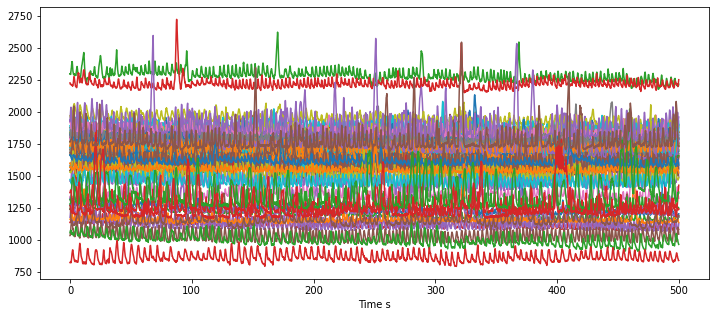

In [227]:
# pull in and organise recordings across the experiment

os.chdir('/Users/finn/Documents/Resp/RITMO/Heaphones_Speakers/Breathing_Data/')
sf = 10
df = pd.DataFrame() 
df['Time s'] = np.arange(5001)/sf
df=df.set_index('Time s')
folders = os.listdir()
folders = sorted(folders)
parts = []
sess = []
for fold in participants: # exclude participants excluded in other studies
    os.chdir(fold)
    files = os.listdir()
    files = sorted(files)
    r = 1
    bf = pd.DataFrame()
    bf['Time s'] = df.index
    bf=bf.set_index('Time s')
    for f in files:
        if f.startswith('S'): # now using the motion capture aligned data 
            if f.endswith('.csv'):
                a = pd.read_csv(f, header=None)
                a['Time s'] = np.arange(len(a))/sf
                a=a.set_index('Time s')
                parts.append(fold)
                sess.append('S'+str(r))
                colName = fold+'-'+str(r)
                r += 1
                df[colName] = a
                bf[colName] = a
    os.chdir('..')

respRecs = [np.array(sess),np.array(parts)]
index = pd.MultiIndex.from_tuples(list(zip(*respRecs)), names=['Session', 'Participants'])
idx = pd.IndexSlice
RespRecs = pd.DataFrame(df.values,index = df.index, columns=index)

RespRecs.plot(figsize=(12,5),legend=False)
plt.show()
#RespRecs.loc[:df.index[5]]

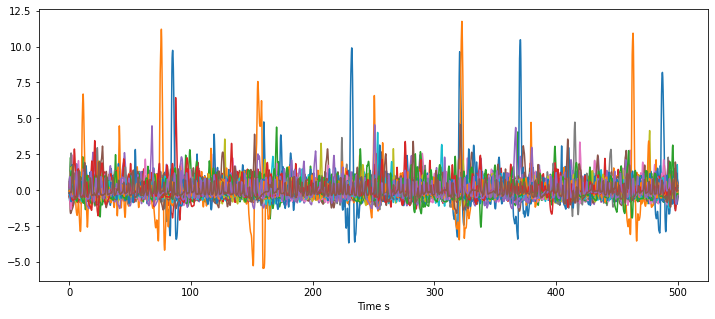

In [228]:
RespNorm=RespRecs.copy()
for part in participants:
    br = pd.DataFrame()
    # gather statistics on breath shapes in original stretch unites across both sessions
    for sess in ['S1','S2']:
        sig = RespRecs.loc[:,idx[sess,part]]
        br = br.append(respy.Breath_Features(sig,scalingfactor=1),ignore_index=True)
    # normalised each sessions resp recording according to statistics across the two
    for sess in ['S1','S2']:
        sig = RespRecs.loc[:,idx[sess,part]]
        newSig=respy.respnormed(sig,scaling=1/br['Depth'].median())
        RespNorm.loc[:,idx[sess,part]]=newSig.iloc[:,0]
RespNorm.plot(figsize=(12,5),legend=False)
plt.show()

# from here, these signals are normalised and filtered 
#    so scaling = 1, filtered = True for respy functions

In [229]:
# dataframe for stimulus times per participant
df_times = pd.DataFrame()

#stimulus_dur= [30, 48.7, 47.9, 47.5, 47.9, 47.6, 47.9] 
stim_names = ['Rest','Rhythm','Andre','Metronome','Neelix1','Neelix2','Pysh']
stimulus_dur = {'Rest':30,'Rhythm':48.7,'Andre':47.9,'Metronome':47.5,'Neelix1':47.9,'Neelix2':47.6,'Pysh':47.9} # seconds, stimulus[0] is the rest period duration

for row in stim_sequence.iterrows():
    seq=row[1]
    ts = [stimulus_dur['Rest']]
    tl = np.zeros(24)
    for i in range(6):
        stim_n = seq[i]
        stim_name = stim_names[stim_n]
        stim_o = i
        if i>0:
            ts.append(ts[-1]+stimulus_dur['Rest'])
        tl[(stim_n-1)*2] = ts[-1]
        ts.append(ts[-1]+stimulus_dur[stim_name])
        tl[(stim_n*2)-1] = ts[-1]
    ts.append(stimulus_dur['Rest'])
    for i in range(6): 
        stim_n = seq[i+6]
        stim_name = stim_names[stim_n] 
        stim_o = i+6
        if i>0:
            ts.append(ts[-1]+stimulus_dur['Rest'])
        tl[(stim_n*2)+10] = ts[-1]
        ts.append(ts[-1]+stimulus_dur[stim_name])
        tl[(stim_n*2)+11] = ts[-1]
    
    df_times = df_times.append(pd.Series(np.round(tl,1)), ignore_index=True)

stimConds = [np.array(['S1','S1','S1','S1','S1','S1','S1','S1','S1','S1','S1','S1','S2','S2','S2','S2','S2','S2','S2','S2','S2','S2','S2','S2']),
         np.array(['Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh','Rhythm','Rest_Rhythm','Andre','Rest_Andre','Metronome','Rest_Metronome','Neelix1','Rest_Neelix1','Neelix2','Rest_Neelix2','Pysh','Rest_Pysh'])]
index = pd.MultiIndex.from_tuples(list(zip(*stimConds)), names=['Session', 'Stimulus'])

#timing information for each stimulus per participant
stimOnsets = pd.DataFrame(df_times.values,index=stim_sequence.index, columns=index)


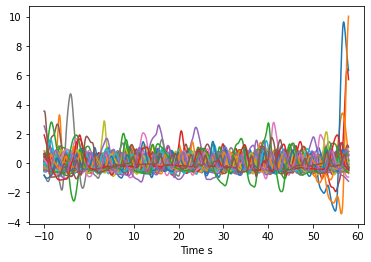

In [7]:
# example extraction of responses corresponditing to a specific stimulus
stim = 'Andre'
buff = 10
dt = pd.DataFrame()
dt['Time s'] = np.round((np.arange(((stimulus_dur[stim]+2*buff)*sf)+1)/sf)-buff,3)
dt=dt.set_index('Time s')

for part in participants:
    for sess in ['S1','S2']:
        # signal, stimulus times, recording condtions
        sig = RespNorm.loc[:,idx[sess,part]]
        
        onsets = stimOnsets.loc[idx[part],idx[sess,:]]
        #pdets = stim_sequence.loc[part]
        sig.index = np.round(sig.index-onsets.loc[idx[sess],idx[stim]],3) # align index
        dt[part+'-'+sess] = sig.loc[-buff:stimulus_dur[stim]+buff]

dt.plot(legend=False)
plt.show()

# Extract respiration phases from a single respiration sequence
parameters on respiration phases...

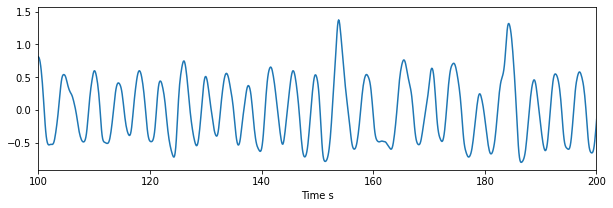

In [247]:
sess = 'S2'
part = 'S25'
sig = RespNorm.loc[:,idx[sess,part]]
sig.plot(figsize=(10,3))
plt.xlim([100,200])
plt.show()

In [150]:
def high_delta_quant(signal_segment, quant):
    ''' high_v reports the indices of high velocity chest expansion/contraction
    on a (binary) phase segment of the respiration cycle, insp or exp  
    signal_segment: timestamp index, single column filtered and normalised chest 
         stretch for a half cycle of resp (signal_segment = sig.loc[insps[i]:exps[i]])
    quant: threshold quantile, [0,1], min extreme for differenced signal segment
    '''
    if signal_segment.diff().mean()>0: # inspiration phase
        bsig = signal_segment.copy()
    else: # expiration phase
        bsig = -signal_segment.copy()
        print('exp')
    a= bsig.diff()
    a.loc[a<0]=np.nan
    thresh = a.quantile(quant)
    ind = bsig.index[a>thresh]
    return ind

def high_delta(signal_segment, thresh):
    ''' high_v reports the indices of high velocity chest expansion/contraction
    on a (binary) phase segment of the respiration cycle, insp or exp  
    signal_segment: timestamp index, single column filtered and normalised chest 
         stretch for a half cycle of resp (signal_segment = sig.loc[insps[i]:exps[i]])
    quant: threshold value, scalar min extreme for differenced signal segment
    '''
    if signal_segment.diff().mean()>0: # inspiration phase
        bsig = signal_segment.copy()
    else: # expiration phase
        bsig = -signal_segment.copy()
        print('exp')
    a= bsig.diff()
    ind = bsig.index[a>thresh]
    return ind

def high_delta_range(signal_segment, scale=0.7):
    ''' high_v reports the indices of high velocity chest expansion/contraction
    on a (binary) phase segment of the respiration cycle, insp or exp  
    signal_segment: timestamp index, single column filtered and normalised chest 
         stretch for a half cycle of resp (signal_segment = sig.loc[insps[i]:exps[i]])
    scale: threshold ration of max, scalar min extreme for differenced signal segment
    '''
    if signal_segment.diff().mean()>0: # inspiration phase
        bsig = signal_segment.copy()
    else: # expiration phase
        bsig = -signal_segment.copy()
    a= bsig.diff()
    max_v = a.max()
    ind = bsig.index[a>a.max()*scale]
    return ind

def post_exp_pause(signal_segment, scale=0.3):
    '''identifies the post expiration pause in the expiration half of the respiration cycle
    '''
    ind = []
    if signal_segment.diff().mean()<0: # expiration phase
        bsig = signal_segment.copy()
        a= bsig.diff()
        min_v = a.min()
        min_i = a.idxmin()
        a.loc[:min_i] = min_v
        ind = bsig.index[a>min_v*scale]
    return ind

In [209]:
# get inspirations

def Resp_phases(sig,scale_high=0.7, scale_low = 0.3):
    ''' Evaluates the respiratory phase components on a respiration signal.
    Inputs: sig - dataframe with single colum of chest expansion sequence, filtered and normalised, index is time stamps
            scale_high - threshold value for high flow rates (via chest expansion rate), used on Insp and Exp
            scale_low - ratio from max expiration value as max for post expiration pause
            defaults for scale derived from coordination analysis in Upham 2018
    Outputs: respPhase - dataframe with index matching input, column per phase component with sig values when phase, np.nan when not
    Note: Not fast, 0.5 s for 10 minutes of resp.
    '''

    #the resp phases data frame
    respPhases = pd.DataFrame(index = sig.index)
    respPhases['Signal'] = sig.values
    sig_diff = sig.diff()
    
    Breaths = respy.Inspiration_Extract(sig) #respy
    respPhases['Inspiration_Onset'] = np.nan
    respPhases['Inspiration_Onset'].loc[Breaths.In]=1
    respPhases['Expiration_Onset'] = np.nan
    respPhases['Expiration_Onset'].loc[Breaths.Ex]=1
    
    # full inspiration phase
    Breaths['In_val'] = True
    Breaths['Exp_val'] = False
    inds = sig.index
    ends = pd.DataFrame(index = [inds[0], inds[-1]],data = [False,False]) 
    df1 = pd.DataFrame(index = Breaths.In, data = Breaths.In_val.values)
    df2 = pd.DataFrame(index = Breaths.Ex, data = Breaths.Exp_val.values)
    onsets = pd.concat([df1,df2,ends])
    onsets = onsets.loc[onsets.index.sort_values()]
    f = interp1d(onsets.index,onsets[0], kind='previous')
    sig_alt=f(sig.index)
    respPhases['Inspiration'] = np.nan
    respPhases['Inspiration'].loc[sig_alt==1] = sig.loc[sig_alt==1]
    respPhases['Inspiration_diff'] = np.nan
    respPhases['Inspiration_diff'].loc[sig_alt==1] = sig_diff.loc[sig_alt==1]

    # full expiration phase
    Breaths['In_val'] = False
    Breaths['Exp_val'] = True
    df1 = pd.DataFrame(index = Breaths.In, data = Breaths.In_val.values)
    df2 = pd.DataFrame(index = Breaths.Ex, data = Breaths.Exp_val.values)
    onsets = pd.concat([df1,df2,ends])
    onsets = onsets.loc[onsets.index.sort_values()]
    f = interp1d(onsets.index,onsets[0], kind='previous')
    sig_alt=f(sig.index)
    respPhases['Expiration'] = np.nan
    respPhases['Expiration'].loc[sig_alt==1] = sig.loc[sig_alt==1]
    respPhases['Expiration_diff'] = np.nan
    respPhases['Expiration_diff'].loc[sig_alt==1] = sig_diff.loc[sig_alt==1]

    # thresholds set to sequence values
    percentileThresh = scale_high # default 0.7 pr 70%, reasonable thresh from Upham 2018
    threshes = respPhases.diff().quantile(percentileThresh)
    threshes['Expiration'] = respPhases['Expiration'].diff().quantile(1-percentileThresh)
    threshes['Expiration_diff'] = respPhases['Expiration_diff'].diff().quantile(1-percentileThresh)

    # sequence-wise high flow moments in insp and exp 
    respPhases['Inspiration_high'] = np.nan
    respPhases['Inspiration_high'].loc[respPhases['Inspiration_diff']
                                     >=threshes['Inspiration']]= sig.loc[respPhases['Inspiration_diff']>=threshes['Inspiration']]
    respPhases['Expiration_high'] = np.nan
    respPhases['Expiration_high'].loc[respPhases['Expiration_diff']
                                     <=threshes['Expiration']]= sig.loc[respPhases['Expiration_diff']<=threshes['Expiration']]
    # breath-wise high flow moments in insp and exp and post expiration interval (low flow)
    respPhases['Inspiration_V'] = np.nan
    respPhases['Expiration_V'] = np.nan
    respPhases['Post_Expiration'] = np.nan

    insps = Breaths['In'].values
    exps = Breaths['Ex'].values
    for i in range(len(insps)-1):
        bsig = sig.loc[insps[i]:exps[i]]
        inde = high_delta_range(bsig, scale_high) 
        respPhases['Inspiration_V'].loc[inde] = bsig.loc[inde]

        bsig = sig.loc[exps[i]:insps[i+1]]
        inde = high_delta_range(bsig, scale_high) 
        respPhases['Expiration_V'].loc[inde] = bsig.loc[inde]
        inde = post_exp_pause(bsig,scale_low)
        respPhases['Post_Expiration'].loc[inde] = bsig.loc[inde]
    return respPhases

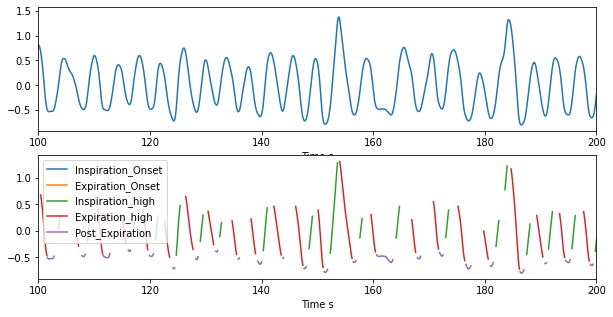

In [249]:
respPhases = Resp_phases(sig, 0.7, 0.3)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(211)
sig.plot(ax=ax)
plt.xlim([100,200]) 
ax = fig.add_subplot(212)
respPhases[Comps].plot(ax=ax)
plt.legend()
plt.xlim([100,200]) 
plt.savefig('phase_components_2.png',dpi = 400)

plt.show()

In [160]:
dt

,S09-S1,S09-S2,S10-S1,S10-S2,S11-S1,S11-S2,S12-S1,S12-S2,S13-S1,S13-S2,...,S35-S1,S35-S2,S36-S1,S36-S2,S38-S1,S38-S2,S39-S1,S39-S2,S41-S1,S41-S2
Time s,,,,,,,,,,,,,,,,,,,,,
-10.0,0.408495,-0.359317,0.241036,-0.270758,-0.152024,-0.493875,0.121051,-0.205234,-0.468877,0.625613,...,0.248164,-0.082400,-0.387158,0.048710,-0.845886,-0.268314,-0.482112,1.921930,-0.439604,3.550098
-9.9,0.518656,-0.379337,0.324125,-0.131988,-0.033373,-0.363337,0.002616,-0.079766,-0.453443,0.686315,...,0.214741,-0.096936,-0.434447,-0.040817,-0.901001,-0.313014,-0.471779,1.820858,-0.476240,3.554286
-9.8,0.593277,-0.385485,0.394045,0.018990,0.088285,-0.198636,-0.106655,0.075053,-0.434624,0.720142,...,0.177473,-0.105092,-0.473058,-0.130235,-0.941361,-0.358078,-0.467972,1.712151,-0.501670,3.426941
-9.7,0.628426,-0.370870,0.441483,0.171499,0.203129,-0.006932,-0.199218,0.240592,-0.412071,0.730697,...,0.132902,-0.110765,-0.499327,-0.212116,-0.969259,-0.398007,-0.472315,1.595489,-0.519710,3.173424
-9.6,0.624979,-0.327800,0.457841,0.318113,0.303893,0.200709,-0.273210,0.392624,-0.383709,0.722175,...,0.073746,-0.120342,-0.512958,-0.279471,-0.990086,-0.429060,-0.482789,1.469949,-0.530221,2.809922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57.5,-0.452024,-0.423000,0.652809,0.016141,0.489429,0.731584,-0.423783,-0.244598,0.644840,0.805836,...,0.087153,-0.353577,0.259559,-0.018596,-0.023627,-0.085527,-0.553391,-0.351650,0.909064,-0.007816
57.6,-0.371154,-0.439721,0.695654,-0.126128,0.621603,0.608856,-0.497766,-0.122561,0.580627,0.844202,...,0.230945,-0.246400,0.192187,-0.078380,-0.099982,-0.131428,-0.580544,-0.386729,0.852516,-0.115258
57.7,-0.273090,-0.450887,0.687688,-0.252527,0.723432,0.455930,-0.565352,0.019795,0.490060,0.859730,...,0.353357,-0.131351,0.125410,-0.122733,-0.160090,-0.167148,-0.607153,-0.412958,0.757263,-0.191409


In [210]:
#phases to ac
component = 'Post_Expiration'
scale_high=0.7
scale_low = 0.3

d_phC = pd.DataFrame(index = dt.index)
part = dt.columns
for i in range(len(part)):
    p = part[i]
    p_phases = Resp_phases(dt[p],scale_high, scale_low)
    v = p_phases[component]
    v.loc[v.notna()] = 1
    v.loc[v.isna()] = 0
    d_phC[i] = v.values # can't have column names in current activity analysis :/

d_phC

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
Time s,,,,,,,,,,,,,,,,,,,,,
-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def trimAct(df_Act,quant=0.25):
    
    K = np.abs(df_Act).sum(axis=1)
    thresh = K.quantile(quant)
    id = K.loc[K > thresh].index
    df_Trimed = df_Act.loc[id[0]:id[-1],:]
    return df_Trimed

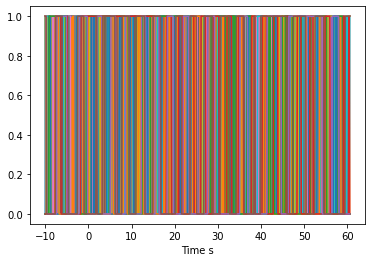

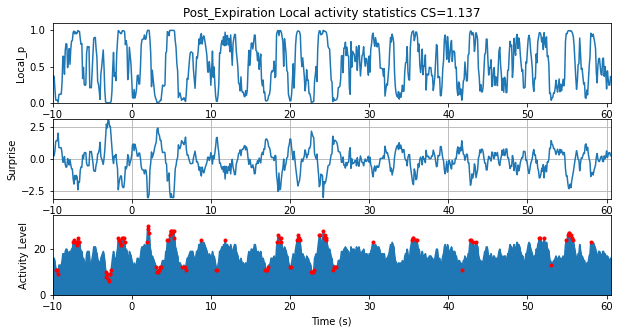

In [242]:
#phases to ac
# component = 'Post_Expiration'
scale_high=0.7
scale_low = 0.3

d_phC = pd.DataFrame(index = dt.index)
part = dt.columns
for i in range(len(part)):
    p = part[i]
    p_phases = Resp_phases(dt[p],scale_high, scale_low)
    v = p_phases[component]
    v.loc[v.notna()] = 1
    v.loc[v.isna()] = 0
    d_phC[i] = v.values # can't have column names in current activity analysis :/

d_trimed = trimAct(d_phC)

FrameSize = 0.2
#Acts=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
ShuffleRange = 10
Iter = 2000
alpha = 0.01
# stest = act.localActivityTest(d_trimed,FrameSize,ShuffleRange,Iter,alpha)


A = stest['MeasuredResults']
B = stest['ActivityPeaks']
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(311)
# plot the activity levels for rating changes (inc/dec)
A['Local_p'].plot(ax=ax)
plt.ylim(0,1.1)
plt.xlim(A.index[0],A.index[-1])
plt.ylabel('Local_p')
plt.xlabel('Time (s)')
plt.title(component + ' Local activity statistics CS='+str(round(stest[ 'CoordScore'],3)))
ax = fig.add_subplot(312)
# plot the activity levels for rating changes (inc/dec)
A['Surprise'].plot(ax=ax)
plt.ylim(-3.1,3.1)
plt.xlim(A.index[0],A.index[-1])
plt.grid()
plt.ylabel('Surprise')
plt.xlabel('Time (s)')

ax = fig.add_subplot(313)
# plot the activity levels for rating changes (inc/dec)
A['Activity-levels'].plot.area(ax=ax)
B['Activity-levels'].plot(style='r.')
plt.ylim(0,35)
plt.xlim(A.index[0],A.index[-1])
plt.ylabel('Activity Level')
plt.xlabel('Time (s)')
plt.savefig(stim + '_local_activity.png',dpi = 400)

plt.show()

5.106467962265015
5.117308855056763
38.80233693122864
72.21175289154053
104.55888676643372
136.48510479927063
168.21307277679443


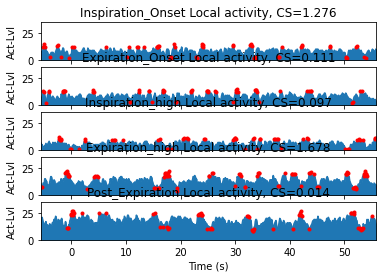

In [217]:
#phases to ac
tic = time.time()

Comps = ['Inspiration_Onset', 'Expiration_Onset', 'Inspiration_high',
       'Expiration_high','Post_Expiration']
windows = {'Inspiration_Onset':0.5, 'Expiration_Onset':0.5, 'Inspiration_high':0.2,
       'Expiration_high':0.2,'Post_Expiration':0.2}

scale_high=0.7
scale_low = 0.3

part = dt.columns
V=[]
for j in range(len(Comps)):
    d_phC = pd.DataFrame(index = dt.index)
    V.append(d_phC)
    
for i in range(len(part)):
    p = part[i]
    p_phases = respy.Resp_phases(dt[p],scale_high, scale_low)
    for j in range(len(Comps)):
        component = Comps[j] #= 'Post_Expiration'
        d_phC = V[j]
        v = p_phases[component]
        v.loc[v.notna()] = 1
        v.loc[v.isna()] = 0
        d_phC[i] = v.values # can't have column names in current activity analysis :/
print(time.time()-tic)

W = []
for j in range(len(Comps)):
    component = Comps[j]
    d_phC = V[j]
    d_trimed = trimAct(d_phC)
    W.append(d_trimed)
print(time.time()-tic)

Z = []
fig, axs = plt.subplots(5,1, sharex='all',figsize=(10,10))
#fig = plt.figure(figsize=(10,10))
for j in range(len(Comps)):
    component = Comps[j]
    d_trimed = W[j]
    FrameSize = windows[component]
    #Acts=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
    ShuffleRange = 10
    Iter = 1000
    alpha = 0.05
    stest = act.localActivityTest(d_trimed,FrameSize,ShuffleRange,Iter,alpha)
    Z.append(stest)
    
    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']

    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot.area(ax=axs[j])
    B['Activity-levels'].plot(style='r.',ax=axs[j])
    axs[j].set_ylim(0,35)
    axs[j].set_xlim(A.index[0],A.index[-1])
    axs[j].set_ylabel('Act-Lvl')
    
    axs[j].set_title(component + ' Local activity, CS='+str(round(stest['CoordScore'],3)))
    print(time.time()-tic)

axs[j].set_xlabel('Time (s)')
plt.show()

Rhythm


<Figure size 720x288 with 0 Axes>

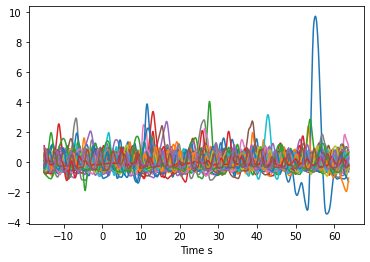

6.576209783554077
6.588619947433472
45.21940875053406
83.38768792152405
119.59452700614929
156.1213619709015
192.60443592071533


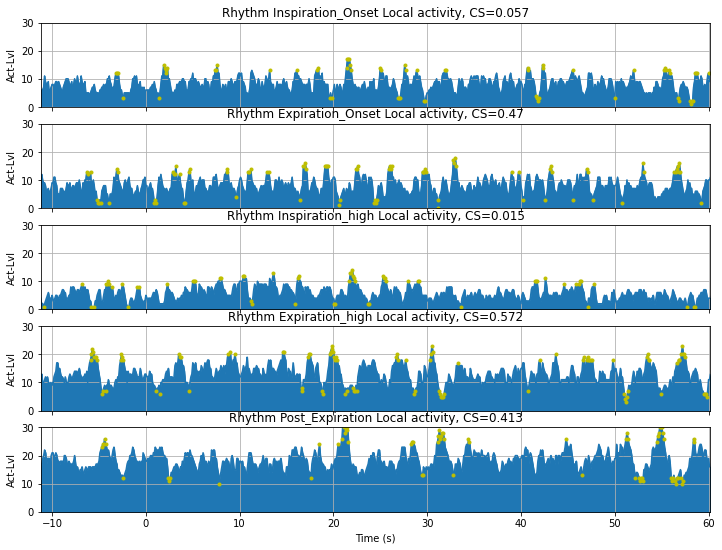

Andre


<Figure size 720x288 with 0 Axes>

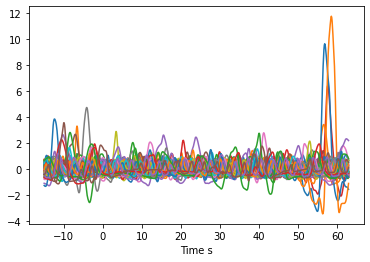

6.315655946731567
6.327680826187134
45.30848789215088
84.62993597984314
119.6736159324646
154.38545989990234
187.2925238609314


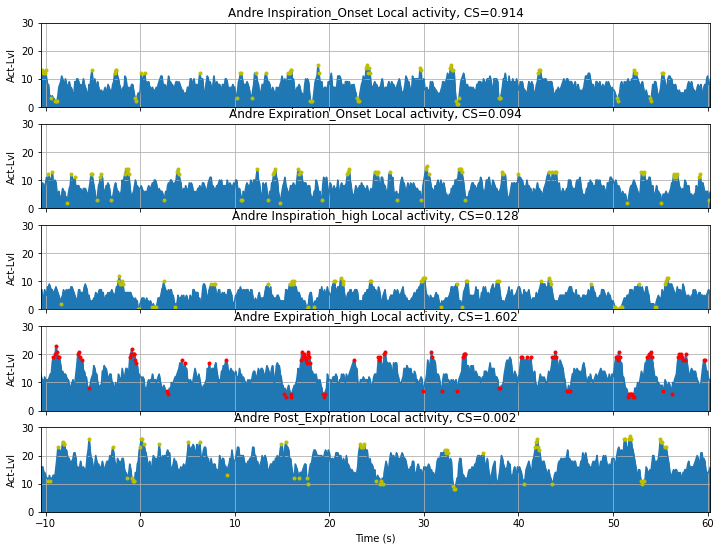

Metronome


<Figure size 720x288 with 0 Axes>

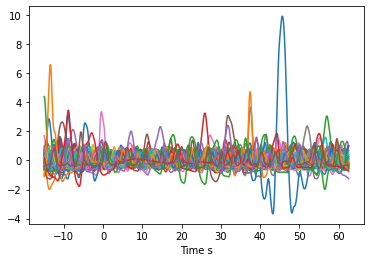

6.071216106414795
6.082780838012695
41.91126608848572
77.31552982330322
132.11019110679626
199.45942282676697
266.7452359199524


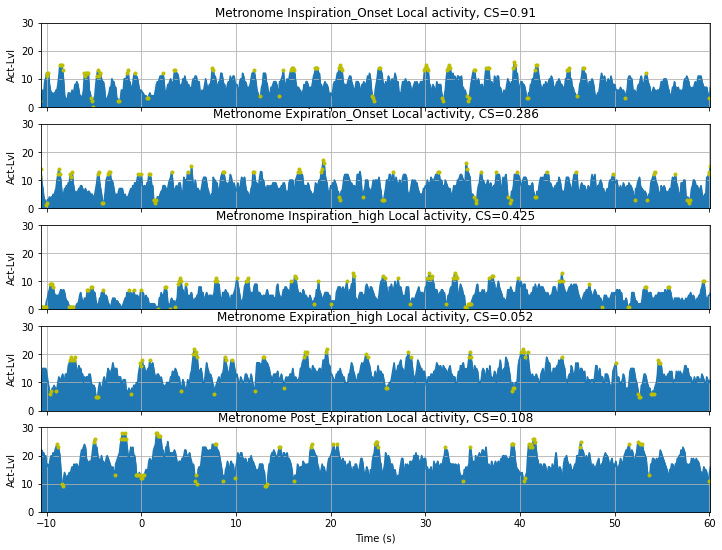

Neelix1


<Figure size 720x288 with 0 Axes>

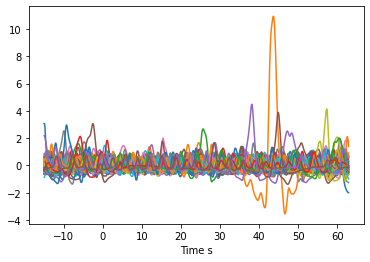

12.303122997283936
12.324274063110352
83.18137717247009
153.3198630809784
220.5878460407257
288.17307806015015
355.6351981163025


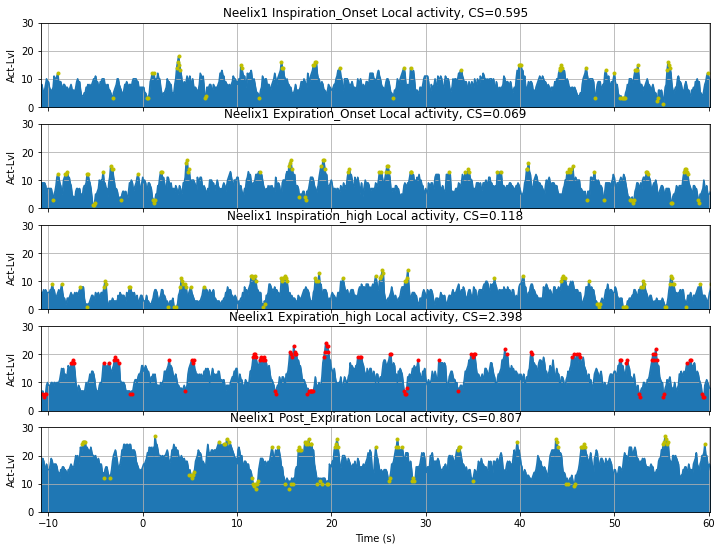

Neelix2


<Figure size 720x288 with 0 Axes>

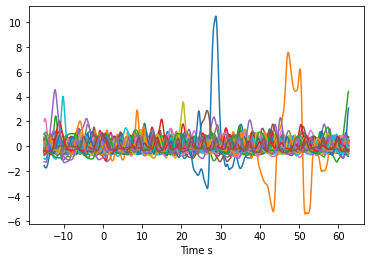

11.879932165145874
11.901217937469482
82.40655303001404
152.43695616722107
184.68132495880127
216.99779987335205
249.01730799674988


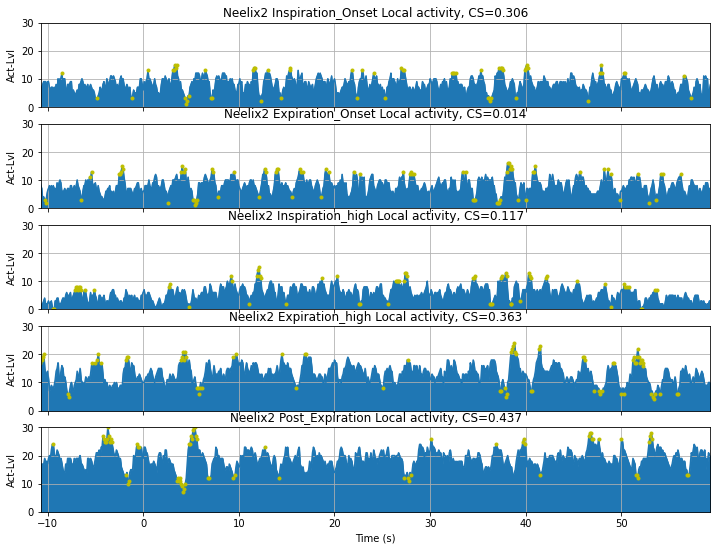

Pysh


<Figure size 720x288 with 0 Axes>

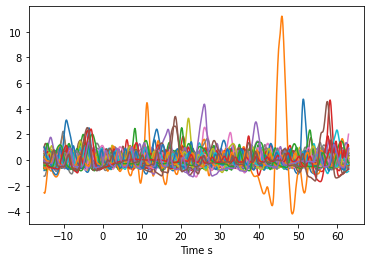

5.552358865737915
5.563245058059692
39.52181887626648
73.33942294120789
105.74502801895142
137.89569997787476
169.89158487319946


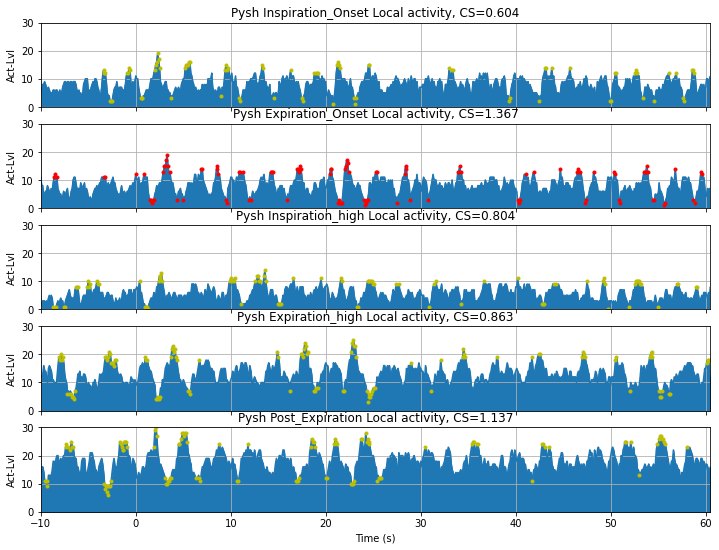

In [234]:
stim_names = ['Rhythm','Andre','Metronome','Neelix1','Neelix2','Pysh']

Comps = ['Inspiration_Onset', 'Expiration_Onset', 'Inspiration_high',
       'Expiration_high','Post_Expiration']
windows = {'Inspiration_Onset':0.5, 'Expiration_Onset':0.5, 'Inspiration_high':0.2,
       'Expiration_high':0.2,'Post_Expiration':0.2}

scale_high=0.7
scale_low = 0.3

buff = 15

for stim in stim_names:
    print(stim)
    tic = time.time()
    
    dt = pd.DataFrame()
    dt['Time s'] = np.round((np.arange(((stimulus_dur[stim]+2*buff)*sf)+1)/sf)-buff,3)
    dt=dt.set_index('Time s')
    for part in participants:
        for sess in ['S1','S2']:
            # signal, stimulus times, recording condtions
            sig = RespNorm.loc[:,idx[sess,part]]
            onsets = stimOnsets.loc[idx[part],idx[sess,:]]
            #pdets = stim_sequence.loc[part]
            sig.index = np.round(sig.index-onsets.loc[idx[sess],idx[stim]],3) # align index
            dt[part+'-'+sess] = sig.loc[-buff:stimulus_dur[stim]+buff]
    
    parts = dt.columns
    V=[]
    for j in range(len(Comps)):
        d_phC = pd.DataFrame(index = dt.index)
        V.append(d_phC)

    for i in range(len(parts)):
        p = parts[i]
        p_phases = respy.Resp_phases(dt[p],scale_high, scale_low)
        for j in range(len(Comps)):
            component = Comps[j] #= 'Post_Expiration'
            d_phC = V[j]
            v = p_phases[component]
            v.loc[v.notna()] = 1
            v.loc[v.isna()] = 0
            d_phC[i] = v.values # can't have column names in current activity analysis :/
    print(time.time()-tic)

    # breath phases can only be assessed on whole cycles, 
    # drop empty ends of responses before running stats.
    W = []
    for j in range(len(Comps)):
        component = Comps[j]
        d_phC = V[j]
        d_trimed = respy.trimAct(d_phC)
        W.append(d_trimed)
    print(time.time()-tic)
    
    Z = []
    fig, axs = plt.subplots(5,1, sharex='all',figsize=(12,9))
    for j in range(len(Comps)):
        component = Comps[j]
        d_trimed = W[j]
        FrameSize = windows[component]
        #Acts=act.activityCount(D['Data'],FrameSize,HopSize,Thresh,'Inc')
        ShuffleRange = 10
        Iter = 1000
        alpha = 0.05
        stest = act.localActivityTest(d_trimed,FrameSize,ShuffleRange,Iter,alpha)
        Z.append(stest)

        A = stest['MeasuredResults']
        B = stest['ActivityPeaks']
        C = stest['CoordScore']
        # plot the activity levels with local activity peaks
        A['Activity-levels'].plot.area(ax=axs[j])
        if C > -np.log10(alpha):
            B['Activity-levels'].plot(style='r.',ax=axs[j])
        else:
            B['Activity-levels'].plot(style='y.',ax=axs[j])
        axs[j].set_ylim(0,30)
        axs[j].set_xlim(A.index[0],A.index[-1])
        axs[j].set_ylabel('Act-Lvl')
        axs[j].grid()
        axs[j].set_title(stim + " " + component + ' Local activity, CS='+str(round(stest['CoordScore'],3)))
        print(time.time()-tic)

    axs[j].set_xlabel('Time (s)')
    plt.savefig(stim + '_phaseActs.png',dpi = 400)

    plt.show()

In [203]:
stest

{'pvalue': 0.945,
 'MeasuredResults':         Activity-levels  Local_p  Surprise
 Time s                                    
 -5.6               15.0    0.475  0.043466
 -5.5               17.0    0.523 -0.039983
 -5.4               21.0    0.893 -0.921468
 -5.3               18.0    0.628 -0.227417
 -5.2               16.0    0.398  0.179713
 ...                 ...      ...       ...
  55.4              19.0    0.748 -0.472501
  55.5              20.0    0.821 -0.661490
  55.6              19.0    0.737 -0.447512
  55.7              17.0    0.502 -0.003474
  55.8              15.0    0.295  0.378367
 
 [615 rows x 3 columns],
 'Models':          0     1     2     3     4     5     6     7     8     9    ...   990  \
 Time s                                                              ...         
 -5.6    15.0  20.0  12.0  15.0  14.0  21.0  13.0  19.0   9.0  23.0  ...  21.0   
 -5.5    16.0  21.0  14.0  15.0  14.0  24.0  13.0  20.0  16.0  26.0  ...  25.0   
 -5.4    14.0  21.0  15.0 